In [1]:
!pip install -qqq ml-collections

In [1]:
import os

os.chdir("..")

In [2]:
import jax
import ml_collections

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import glob
from datetime import datetime

import experiments.movielens_exp as movielens_run
import experiments.mnist_exp as mnist_run
import experiments.tabular_exp as tabular_run
import experiments.tabular_subspace_exp as tabular_sub_run

%load_ext autoreload
%autoreload 2

print(jax.device_count())

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: TPU Interpreter Host


8


# Run tabular experiments

In [3]:
def get_config(filepath):
  """Get the default hyperparameter configuration."""
  config = ml_collections.ConfigDict()
  config.filepath = filepath
  #bandits/results/tabular_results.csv
  config.ntrials = 10
  return config

In [6]:
tabular_filename = f"./results/tabular_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(tabular_filename)
tabular_run.main(config)

Environment :  shuttle
	Bandit : Linear
		Expected Reward : 4426.40 ± 9.98
		Time : 8.391s
	Bandit : Linear KF
		Expected Reward : 4426.50 ± 12.08
		Time : 6.043s
	Bandit : Linear Wide
		Expected Reward : 4208.80 ± 7.95
		Time : 11.995s
	Bandit : Limited Neural Linear
		Expected Reward : 3864.80 ± 17.77
		Time : 17.298s
	Bandit : Unlimited Neural Linear
		Expected Reward : 4150.40 ± 16.27
		Time : 17.494s
	Bandit : EKF Subspace SVD
		Expected Reward : 4595.60 ± 164.23
		Time : 17.698s
	Bandit : EKF Subspace RND
		Expected Reward : 4846.50 ± 2.06
		Time : 17.170s
	Bandit : EKF Diagonal Subspace SVD
		Expected Reward : 4833.00 ± 0.00
		Time : 1.863s
	Bandit : EKF Diagonal Subspace RND
		Expected Reward : 4783.00 ± 0.00
		Time : 1.764s
	Bandit : EKF Orig Diagonal
		Expected Reward : 3594.20 ± 950.41
		Time : 2.011s
	Bandit : EKF Orig Full
		Expected Reward : 3912.10 ± 6.22
		Time : 42.153s
Environment :  covertype
	Bandit : Linear
		Expected Reward : 3024.80 ± 15.75
		Time : 16.138s
	Band

# Plot results

In [7]:
def plot_figure(data, x, y, filename=None, figsize=(24, 9), log_scale=False):   
    sns.set(font_scale=1.5)
    plt.style.use("seaborn-poster")

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    g = sns.barplot(x=x, y=y, hue="Method", data=data, errwidth=2, ax=ax, palette=colors)
    if log_scale:
        g.set_yscale("log")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [8]:
def read_data(dataset_name, results_filename):
    #df = pd.read_csv(f"bandits/results/{dataset_name}_results.csv")
    df = pd.read_csv(results_filename)
    if dataset_name=="mnist":
        linear_df = df[(df["Method"]=="Lin-KF") | (df["Method"]=="Lin")].copy()
        linear_df["Model"] = "MLP2"
        df = df.append(linear_df)
        linear_df["Model"] = "LeNet5"
        df = df.append(linear_df)

    by = ["Rank"] if dataset_name=="tabular" else ["Rank", "AltRank"]

    data_up = df.sort_values(by=by).copy()
    data_down = df.sort_values(by=by).copy()

    data_up["Reward"] = data_up["Reward"] + data_up["Std"]
    data_down["Reward"] = data_down["Reward"] - data_down["Std"]
    data = pd.concat([data_up, data_down])
    return data

In [9]:
method_ordering = {"EKF-Sub-SVD": 0,
                   "EKF-Sub-RND": 1,
                   "EKF-Sub-Diag-SVD": 2,
                   "EKF-Sub-Diag-RND": 3,
                   "EKF-Orig-Full": 4,
                   "EKF-Orig-Diag": 5,
                   "NL-Lim": 6,
                   "NL-Unlim": 7,
                   "Lin": 8,
                   "Lin-KF": 9,
                   "Lin-Wide": 9,
                   "Lim2": 10,
                   "NeuralTS": 11}
                   
colors = {k : sns.color_palette("Paired")[v] if k!="Lin-KF" else  sns.color_palette("tab20")[8] for k,v in method_ordering.items()}

In [11]:
dataset_name = "tabular"
tabular_filename = sorted(glob.glob(f"./results/{dataset_name}_results*.csv"))[-1]
tabular_df = read_data(dataset_name,tabular_filename)
#tabular_rows = [child.description for child in tabular_menu.children if child.value]
tabular_rows = ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND', 'EKF-Orig-Full', 
'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin', 'Lim2', 'NeuralTS']
tabular_df = tabular_df[tabular_df['Method'].isin(tabular_rows)]

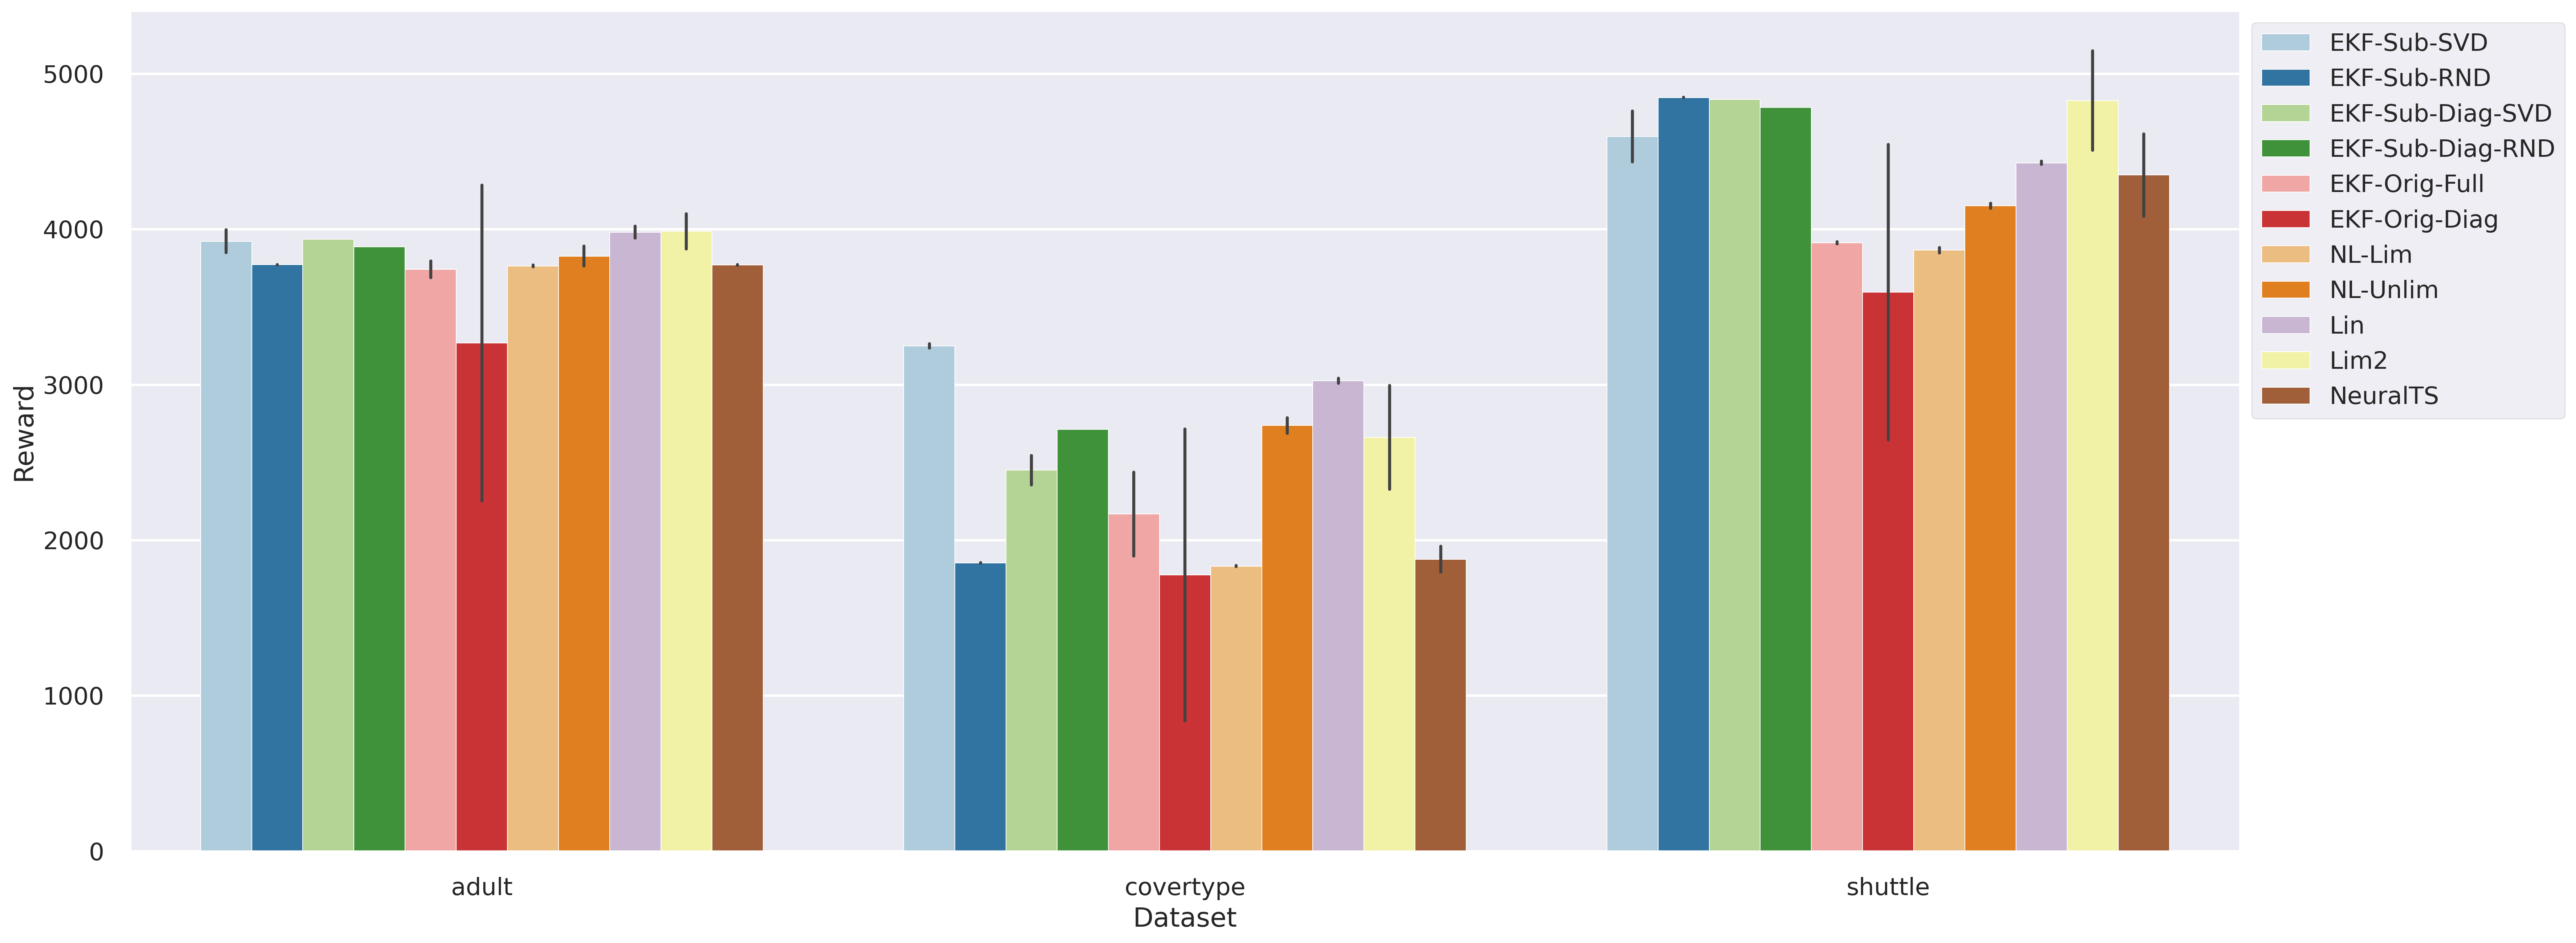

In [12]:
x, y = "Dataset", "Reward"
filename = "tabular_reward.png"
plot_figure(tabular_df, x, y, filename)

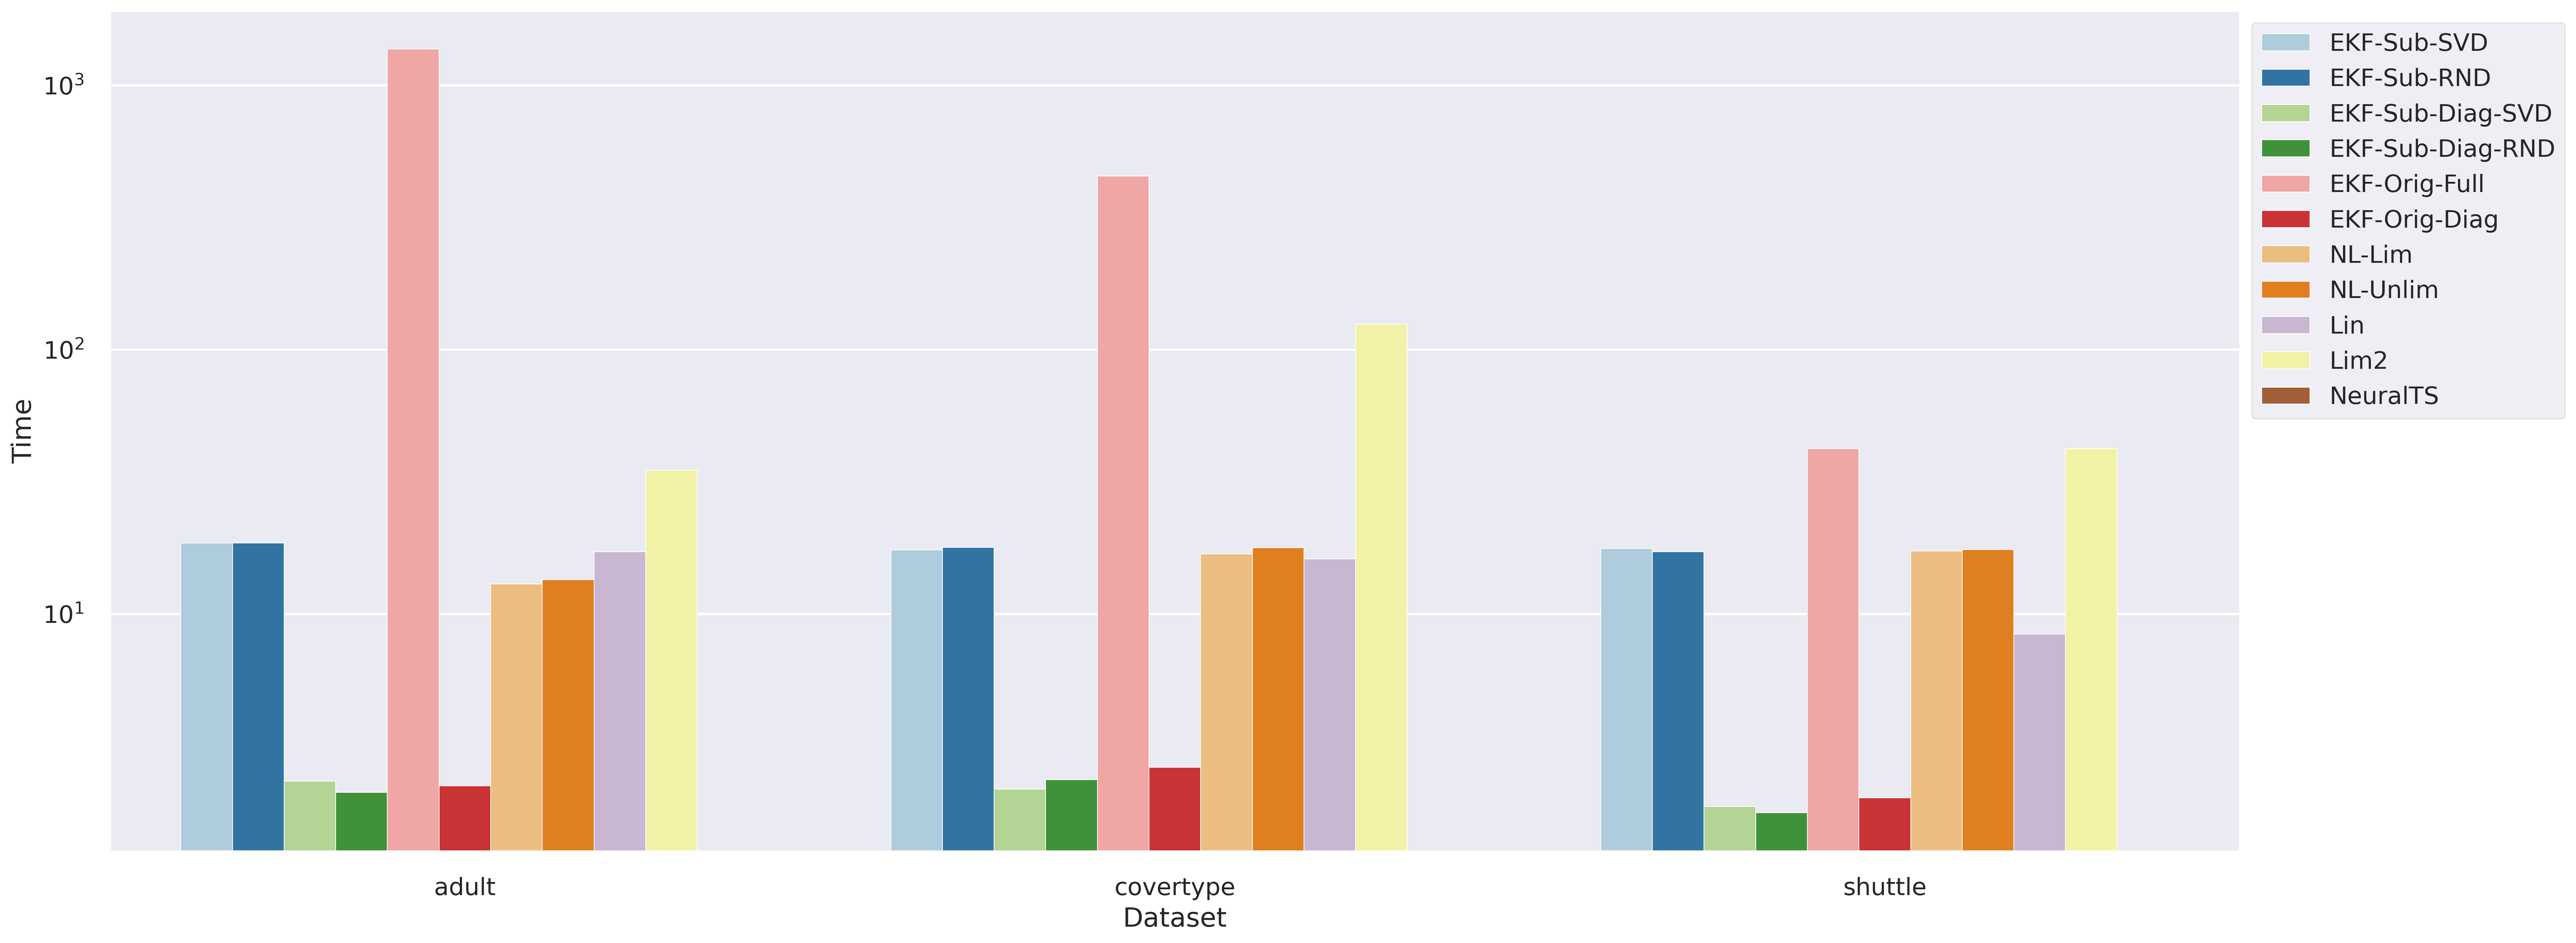

In [13]:
x, y = "Dataset", "Time"
filename = "tabular_time.png"
plot_figure(tabular_df, x, y, filename, log_scale=True)

# Run MNIST experiments

In [ ]:
mnist_filename = f"./results/mnist_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(mnist_filename)
mnist_run.main(config)

Model : MLP1
	Bandit : Linear


# Plot results

In [13]:
dataset_name = "mnist"
mnist_filename = sorted(glob.glob(f"./results/mnist_results*.csv"))[-1]
mnist_df = read_data(dataset_name, mnist_filename)
mnist_rows = ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND', 'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin']
mnist_df = mnist_df[mnist_df['Method'].isin(mnist_rows)]

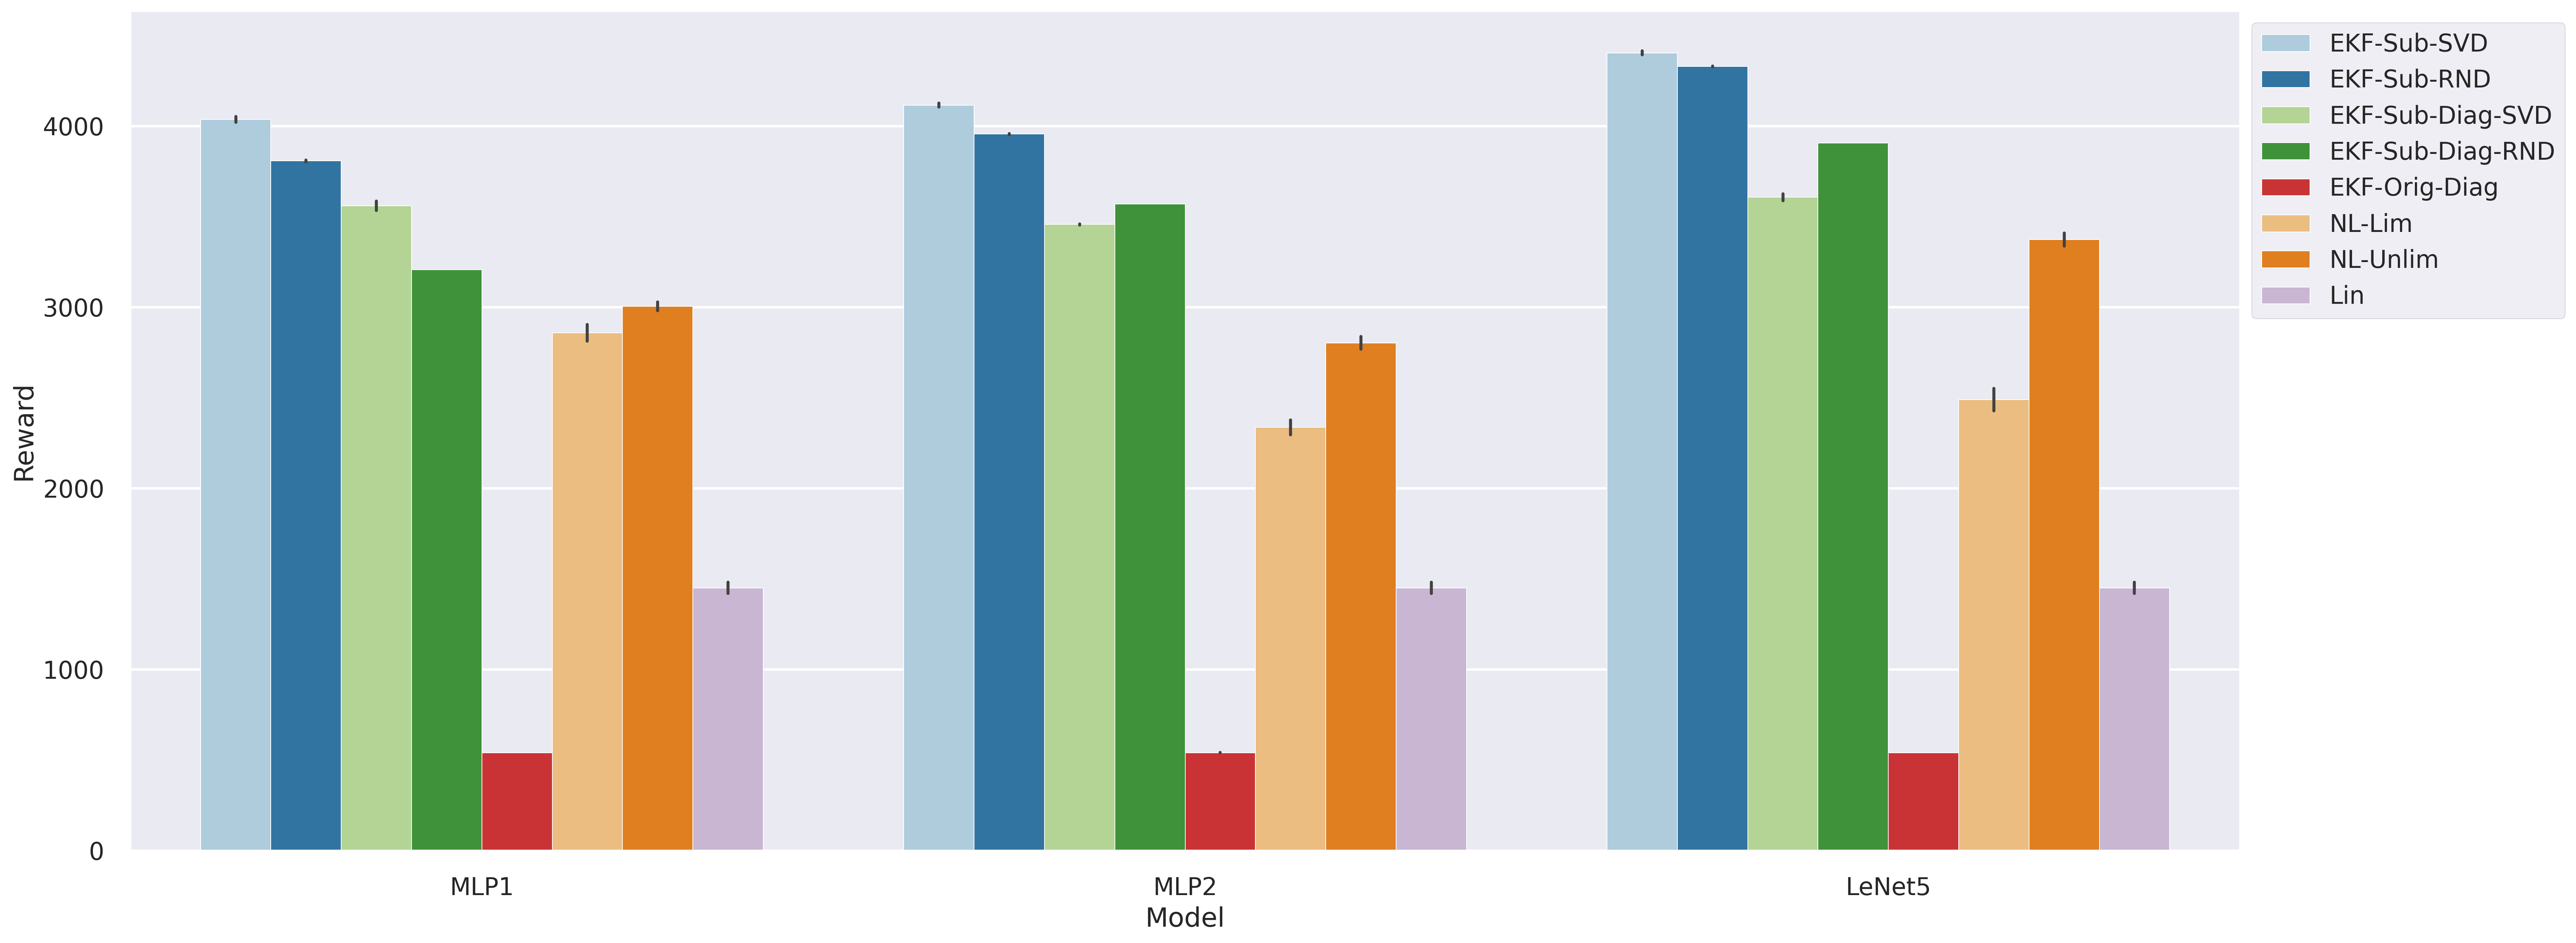

In [14]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(mnist_df, x, y, filename)

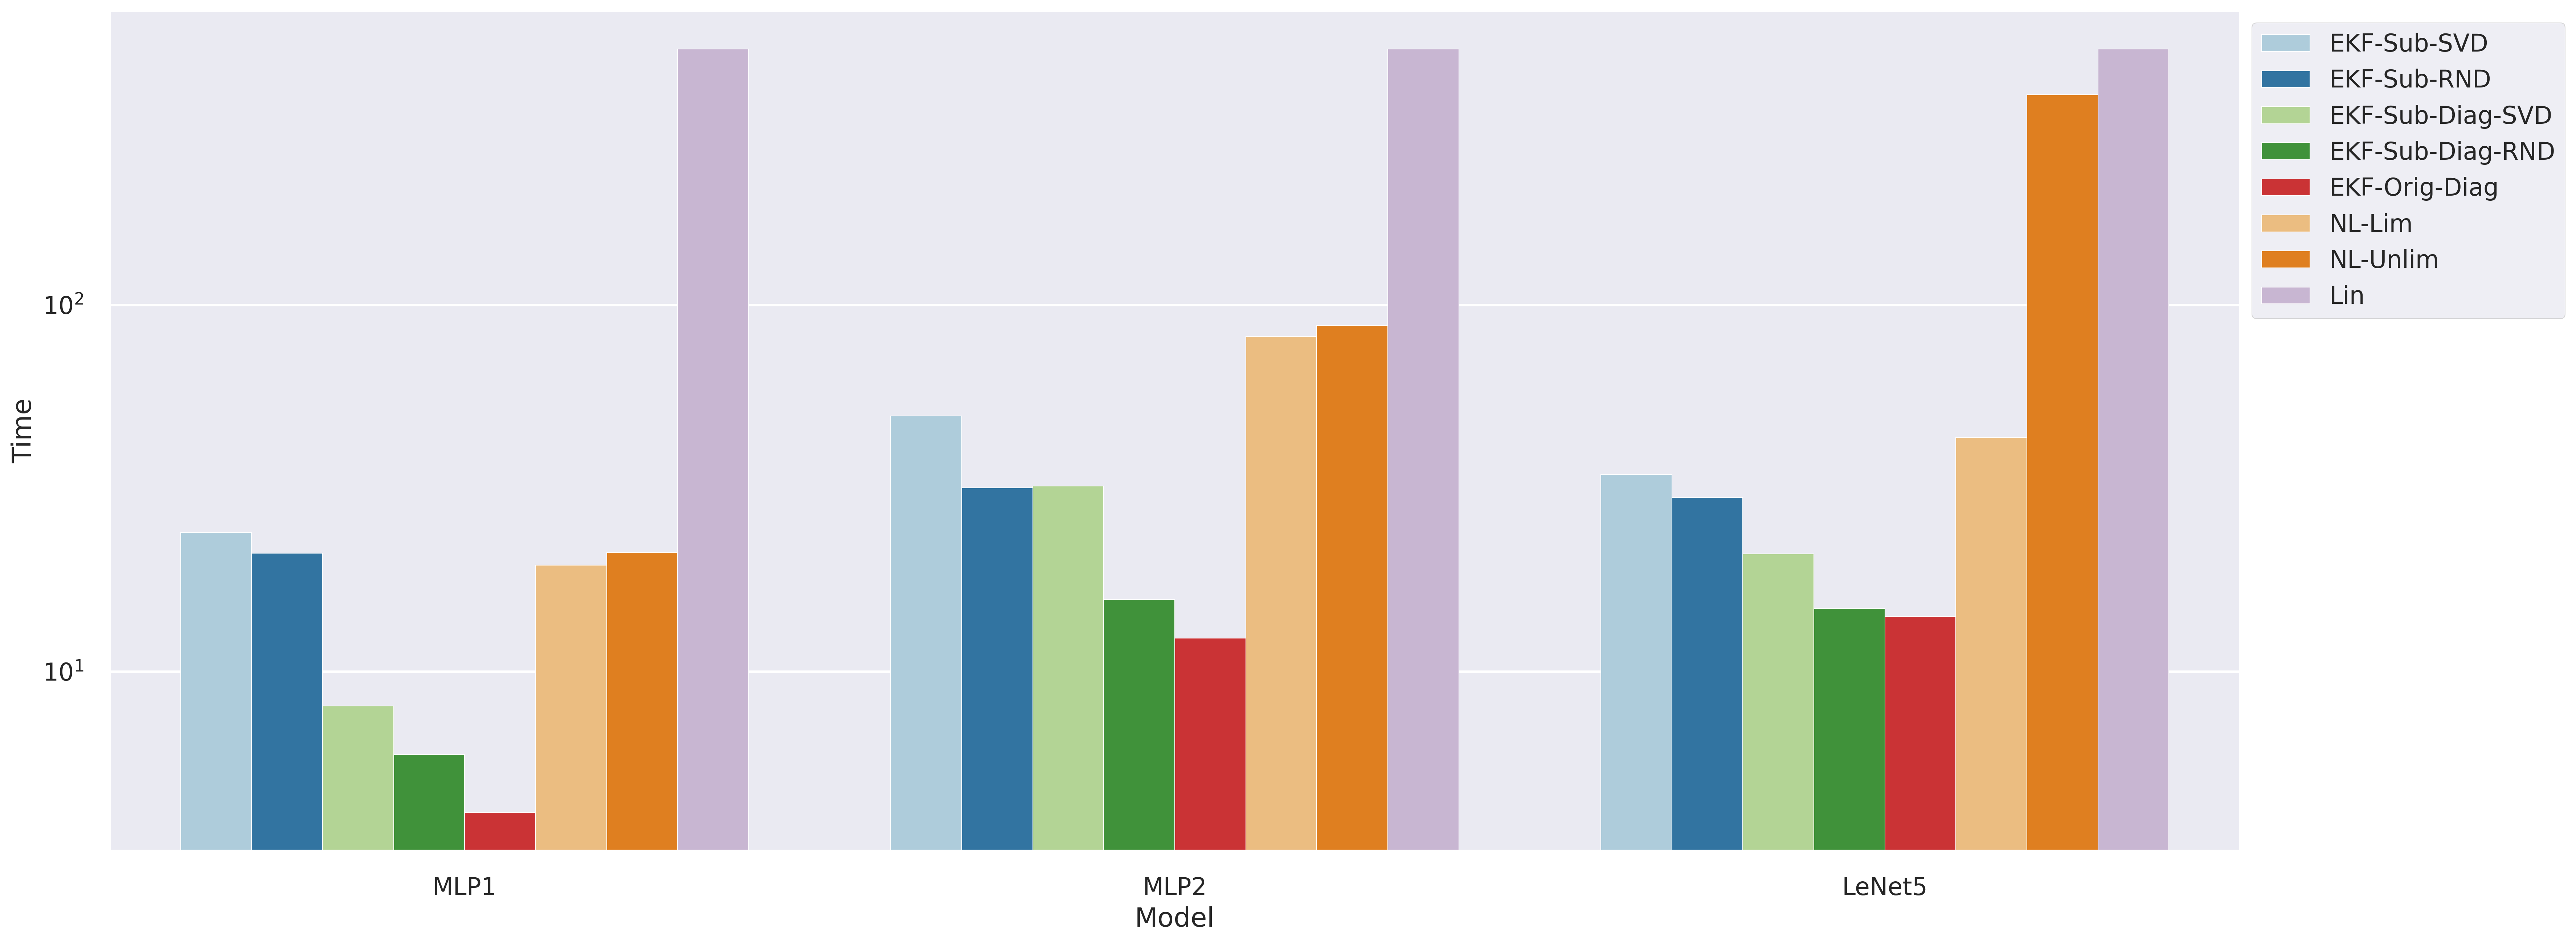

In [15]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(mnist_df, x, y, filename, log_scale=True)

# Run movielens experiments

In [16]:
movielens_filename = f"./results/movielens_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(movielens_filename)
movielens_run.main(config)

Bandit : Linear
	Expected Reward : 2684.10 ± 42.98
	Time : 6.137812376022339
Bandit : Linear KF
	Expected Reward : 2684.10 ± 42.98
	Time : 5.0025553703308105
Bandit : Limited Neural Linear
	Expected Reward : 2049.70 ± 27.32
	Time : 9.099556684494019
Bandit : Unlimited Neural Linear
	Expected Reward : 2328.10 ± 21.45
	Time : 9.56499195098877
Bandit : EKF Subspace SVD
	Expected Reward : 3244.60 ± 1.56
	Time : 5.577503204345703
Bandit : EKF Subspace RND
	Expected Reward : 3240.90 ± 0.54
	Time : 5.3849406242370605
Bandit : EKF Diagonal Subspace SVD
	Expected Reward : 3233.00 ± 0.00
	Time : 1.926344633102417
Bandit : EKF Diagonal Subspace RND
	Expected Reward : 3232.00 ± 0.00
	Time : 1.325103759765625
Bandit : EKF Orig Diagonal
	Expected Reward : 1710.70 ± 12.10
	Time : 1.269505262374878
Bandit : Linear
	Expected Reward : 2684.10 ± 42.98
	Time : 5.518723487854004
Bandit : Linear KF
	Expected Reward : 2684.10 ± 42.98
	Time : 4.911029577255249
Bandit : Limited Neural Linear
	Expected Reward :

# Plot results

In [17]:
dataset_name = "movielens"
movielens_filename = sorted(glob.glob(f"./results/movielens_results*.csv"))[-1]
movielens_df = read_data(dataset_name, movielens_filename)
movielens_rows =  ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND', 'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin']
movielens_df = movielens_df[movielens_df['Method'].isin(movielens_rows)]

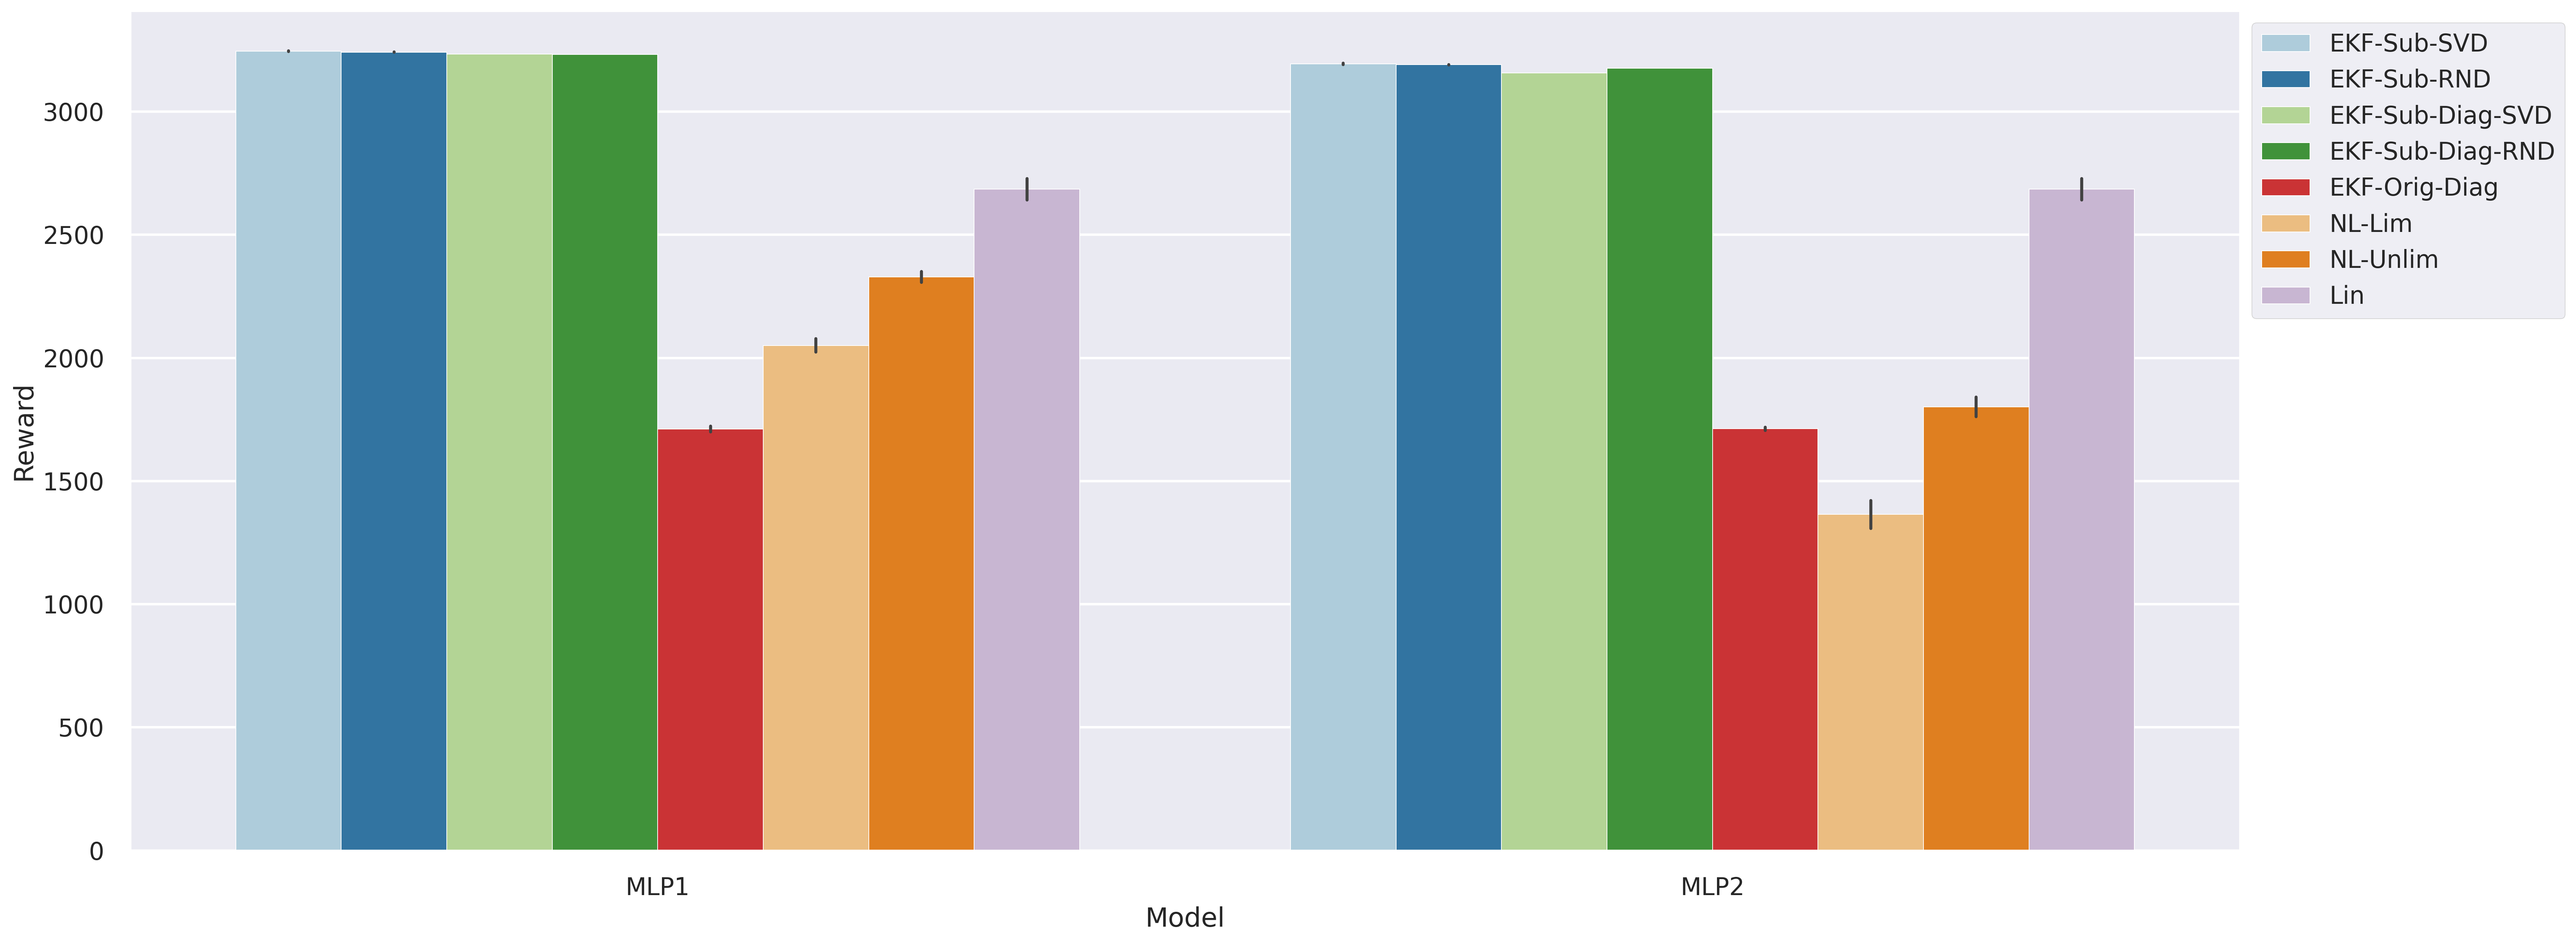

In [18]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(movielens_df, x, y, filename)

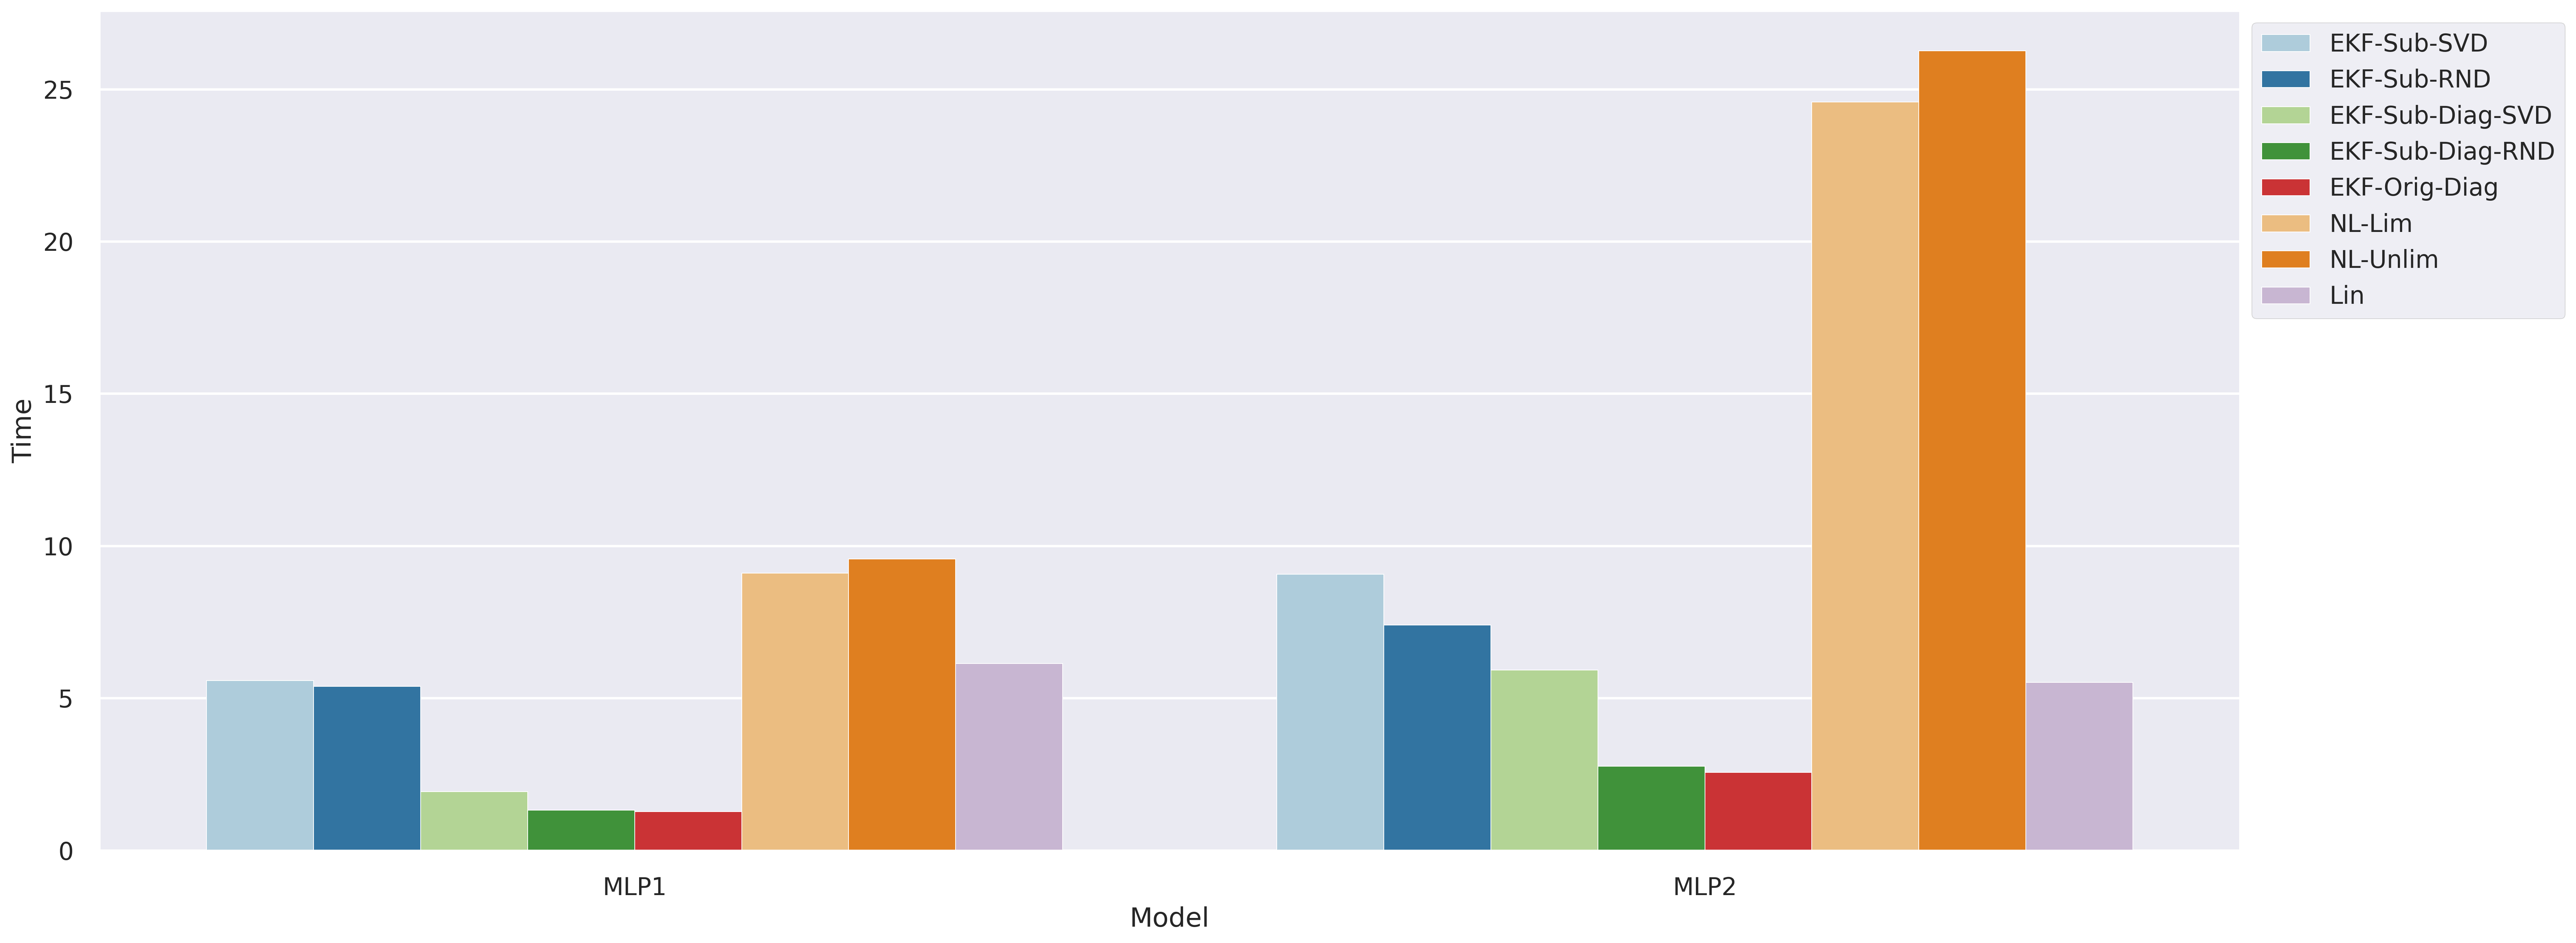

In [19]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}.png"
plot_figure(movielens_df, x, y, filename)

# Run tabular subspace experiment

In [20]:
tabular_sub_filename = f"./results/tabular_subspace_results_{datetime.timestamp(datetime.now())}.csv"
config = get_config(tabular_sub_filename)
tabular_sub_run.main(config)

Environment :  shuttle
	Bandit : EKF Subspace SVD
		Expected Reward : 4807.00 ± 1.55
		Time : 2.4924933910369873
	Bandit : EKF Subspace RND
		Expected Reward : 4815.60 ± 0.49
		Time : 2.090127468109131
	Bandit : EKF Subspace SVD
		Expected Reward : 4820.50 ± 0.50
		Time : 1.98087739944458
	Bandit : EKF Subspace RND
		Expected Reward : 4616.50 ± 5.90
		Time : 2.123654365539551
	Bandit : EKF Subspace SVD
		Expected Reward : 4811.80 ± 2.14
		Time : 2.02278208732605
	Bandit : EKF Subspace RND
		Expected Reward : 4764.40 ± 0.92
		Time : 2.1066529750823975
	Bandit : EKF Subspace SVD
		Expected Reward : 4775.50 ± 3.50
		Time : 2.073242425918579
	Bandit : EKF Subspace RND
		Expected Reward : 4778.30 ± 0.64
		Time : 2.1400110721588135
	Bandit : EKF Subspace SVD
		Expected Reward : 4641.10 ± 2.43
		Time : 2.0911009311676025
	Bandit : EKF Subspace RND
		Expected Reward : 4812.00 ± 1.90
		Time : 2.2563748359680176
	Bandit : EKF Subspace SVD
		Expected Reward : 4660.00 ± 46.01
		Time : 2.2219600677

## Plot results

In [147]:
def plot_subspace_figure(df, filename):
  sns.set_palette("tab10")
  df = df.reset_index().drop(columns=["index"])
  fig, ax = plt.subplots(figsize=(12, 8))
  sns.lineplot(x="Subspace Dim", y="Reward", hue="Method", marker="o", data=df)
  lines, labels = ax.get_legend_handles_labels()
  
  for line, method in zip(lines, labels):
    data = df[df["Method"]==method]
    color = line.get_c()
    ax.fill_between(data["Subspace Dim"],  data["Reward"] -  data["Std"],  data["Reward"] + data["Std"], color=color, alpha=0.3)
   
  ax.set_ylabel("Reward", fontsize=16)
  plt.setp(ax.get_xticklabels(), fontsize=16) 
  plt.setp(ax.get_yticklabels(), fontsize=16) 
  ax.set_xlabel("Subspace Dimension(d)", fontsize=16)
  dataset = df.iloc[0]["Dataset"]
  ax.set_title(f"{dataset.title()} - Subspace Dim vs. Reward", fontsize=18)
  legend = ax.legend(loc="lower right", prop={'size': 16},frameon=1)
  frame = legend.get_frame()
  frame.set_color('white')
  frame.set_alpha(0.6)
  plt.savefig(filename, dpi=300)
  plt.show()

In [148]:
tabular_sub_df = pd.read_csv(sorted(glob.glob("./results/tabular_subspace_results*.csv"))[-1])

## Shuttle

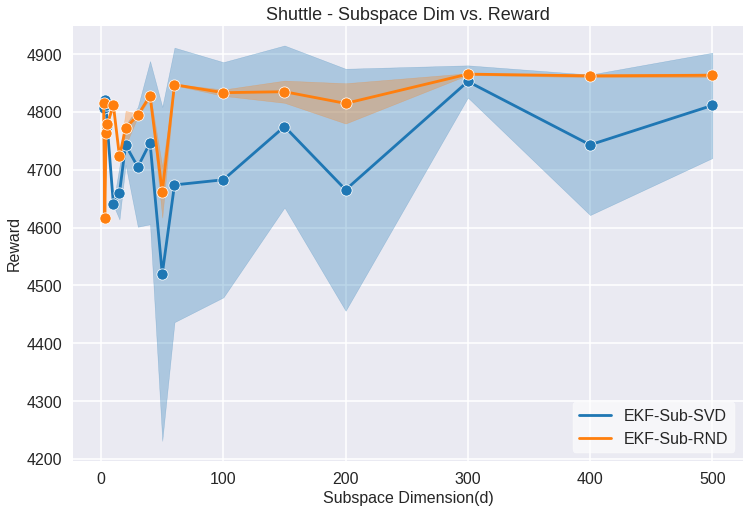

In [149]:
dataset_name = "shuttle"
filename = f"{dataset_name}_sub.png"
shuttle = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(shuttle, filename)

## Adult

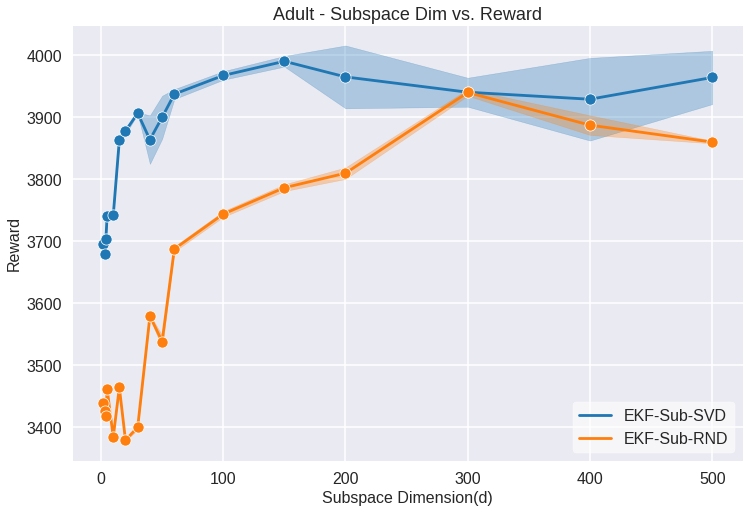

In [150]:
dataset_name = "adult"
filename = f"{dataset_name}_sub.png"
adult = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(adult, filename)

## Covertype

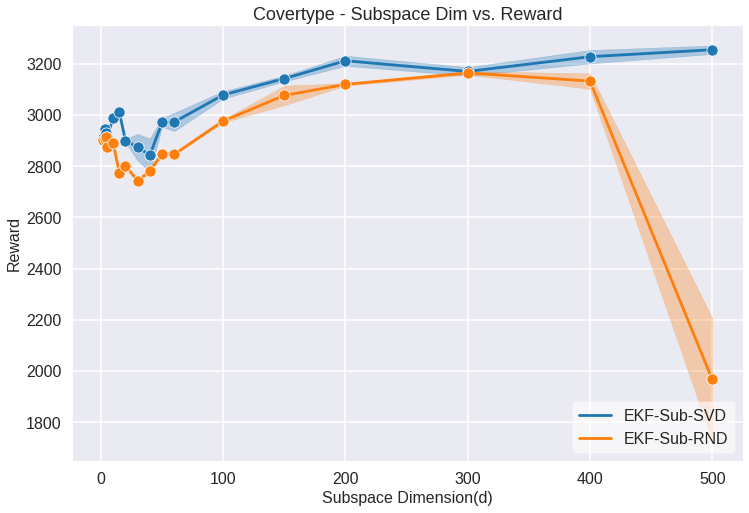

In [151]:
dataset_name = "covertype"
filename = f"{dataset_name}_sub.png"
covertype = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(covertype, filename)